# DeepHyper 101

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deephyper/tutorials/blob/main/tutorials/colab/DeepHyper_101.ipynb)


In this tutorial, we present the basics of DeepHyper.

Let us start with installing DeepHyper!

In [2]:
try:
    import deephyper
    print(deephyper.__version__)
except (ImportError, ModuleNotFoundError):
    !pip install deephyper

0.6.0


## Optimization Problem

In the definition of our optimization problem we have two components:

1. black-box function that we want to optimize
2. the search space of input variables

### Black-Box Function

DeepHyper is developed to optimize black-box functions. Here, we define the function $f(x) = - x ^ 2$ that we want to maximise (the maximum being $f(x=0) = 0$ on $I_x = [-10;10]$). The black-box function `f` takes as input a `config` dictionary from which we retrieve the variables of interest.

In [3]:
def f(job):
    return -job.parameters["x"] ** 2

### Search Space of Input Variables

In this example, we have only one variable $x$ for the black-box functin $f$. We empirically decide to optimize this variable $x$ on the interval $I_x = [-10;10]$. To do so we use the `HpProblem` from DeepHyper and add a **real** hyperparameter by using a `tuple` of two `floats`.

In [4]:
from deephyper.problem import HpProblem


problem = HpProblem()

# Define the variable you want to optimize
problem.add_hyperparameter((-10.0, 10.0), "x")

problem

Configuration space object:
  Hyperparameters:
    x, Type: UniformFloat, Range: [-10.0, 10.0], Default: 0.0

## Evaluator Interface

DeepHyper uses an API called `Evaluator` to distribute the computation of black-box functions and adapt to different backends (e.g., threads, processes, MPI, Ray). An `Evaluator` object wraps the black-box function `f` that we want to optimize. Then a `method` parameter is used to select the backend and `method_kwargs` defines some available options of this backend. 

<div class="alert alert-info">
    
<b>Tip</b>

The `method="thread"` provides parallel computation only if the black-box is releasing the global interpretor lock (GIL). Therefore, if you want parallelism in Jupyter notebooks you should use the Ray evaluator (`method="ray"`) after installing Ray with `pip install ray`.
</div>

It is possible to define callbacks to extend the behaviour of `Evaluator` each time a function-evaluation is launched or completed. In this example we use the `TqdmCallback` to follow the completed evaluations and the evolution of the objective with a progress-bar.

In [6]:
from deephyper.evaluator import Evaluator
from deephyper.evaluator.callback import TqdmCallback


# define the evaluator to distribute the computation
evaluator = Evaluator.create(
    f,
    method="thread",
    method_kwargs={
        "num_workers": 4,
        "callbacks": [TqdmCallback()]
    },
)

print(f"Evaluator has {evaluator.num_workers} available worker{'' if evaluator.num_workers == 1 else 's'}")

Evaluator has 4 available workers


## Search Algorithm

The next step is to define the search algorithm that we want to use. Here, we choose `CBO` (Centralized Bayesian Optimization) which is a sampling based Bayesian optimization strategy. This algorithm has the advantage of being asynchronous thanks to a constant liar strategy which is crutial to keep a good utilization of the resources when the number of available workers increases.

In [7]:
from deephyper.search.hps import CBO

# define your search
search = CBO(
    problem,
    evaluator,
    acq_func="UCB",  # Acquisition function to Upper Confidence Bound
    multi_point_strategy="qUCB",  # Fast Multi-point strategy with q-Upper Confidence Bound
    n_jobs=2,  # Number of threads to fit surrogate models in parallel
)

Then, we can execute the search for a given number of iterations by using the `search.search(max_evals=...)`. It is also possible to use the `timeout` parameter if one needs a specific time budget (e.g., restricted computational time in machine learning competitions, allocation time in HPC).

In [8]:
results = search.search(max_evals=100)

  0%|          | 0/100 [00:00<?, ?it/s]

Finally, let us visualize the results. The `search(...)` returns a DataFrame also saved locally under `results.csv` (in case of crash we don't want to lose the possibly expensive evaluations already performed). 

The DataFrame contains as columns:
1. the optimized hyperparameters: such as `x` in our case.
2. the `job_id` of each evaluated function (increased incrementally following the order of created evaluations).
4. the `objective` **maximised** which directly match the results of the $f$-function in our example.
5. the time of creation/collection of each task timestamp_submit and timestamp_gather respectively (in secondes, since the creation of the Evaluator).

In [9]:
results

,p:x,objective,job_id,m:timestamp_submit,m:timestamp_gather
0,5.158482,-2.660994e+01,1,5.408207,5.410271
1,6.138799,-3.768485e+01,3,5.408318,5.449186
2,3.312879,-1.097517e+01,2,5.408243,5.450632
3,2.589174,-6.703821e+00,0,5.408132,5.452201
4,-1.399978,-1.959937e+00,4,5.590530,5.593016
...,...,...,...,...,...
95,-0.000188,-3.515852e-08,94,12.333142,12.336986
96,0.000442,-1.957323e-07,96,12.601563,12.602302
97,-0.001094,-1.196771e-06,97,12.601587,12.603551
98,-0.001094,-1.196771e-06,98,12.601603,12.604581


We can also plot the evolution of the objective to verify that we converge correctly toward $0$.

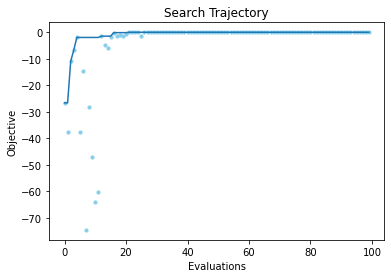

In [14]:
from deephyper.analysis.hpo import plot_search_trajectory_single_objective_hpo
import matplotlib.pyplot as plt

fig, ax = plot_search_trajectory_single_objective_hpo(results)
plt.title("Search Trajectory")
plt.show()  